# Initiation au traitement automatique du langage (NLP )

Le traitement automatique du Langage Naturel est un des domaines de recherche les plus actifs en science des données actuellement. C’est un domaine à l’intersection du Machine Learning et de la linguistique. Il a pour but d’extraire des informations et une signification d’un contenu textuel. 

* Le Traitement Automatique du Langage naturel (TAL) ou Natural Language Processing (NLP) en anglais trouve de nombreuses applications dans la vie de tous les jours :
    * traduction de texte (DeepL par exemple)
    * correcteur orthographique
    * résumé automatique d’un contenu
    * synthèse vocale
    * classification de texte
    * analyse d’opinion/sentiment
    * prédiction du prochain mot sur smartphone
    * extraction des entités nommées depuis un texte
    * …

<div class="alert-info">
La plupart des ressources disponibles actuellement sont en anglais, ce qui implique que la plupart des modèles pré-entraînés sont également spécifiques à la langue anglaise. Cependant, il existe des librairies et des outils en français pour accomplir les tâches mentionnées ci-dessus. Nous allons les voir dans cet article.      
</div>

* Le TAL (traitement automatique du langage) est généralement composé de deux à trois grandes étapes:
    * Pré-traitement : une étape qui cherche à standardiser du texte afin de rendre son usage plus facile
    * Représentation du texte comme un vecteur : Cette étape peut être effectuée via des techniques de sac de mots (Bag of Words) ou Term Frequency-Inverse Document Frequency (Tf-IdF). On peut également apprendre des représentations vectorielles (embedding) par apprentissage profond.
    * Classification, trouver la phrase la plus similaire… (optionnel).

<div class="alert-warning">
Nous utiliserons principalement SpaCy. SpaCy est une jeune librairie (2015) qui offre des modèles pré-entraînés pour diverses applications, y compris la reconnaissance d’entités nommées. SpaCy est la principale alternative à NLTK (Natural Language Tool Kit), la librairie historique pour le TAL avec Python, et propose de nombreuses innovations et options de visualisation qui sont très intéressantes.
</div>

**Objectif de ce notebook** : Le but de ce tutoriel est de déterminer si un texte est considéré comme un spam ou non. **Dataset** : Nous utiliserons un dataset composé de 1956 commentaires labellisés (spam : 1, ham : 0) en provenance de 5 vidéos YouTube populaires en 2012. Les données sont disponibles [ici](https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection).

In [60]:
import pandas as pd
from IPython import display
import string

#for machine learning - classification
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

#for NLP
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from nltk.corpus import stopwords

In [130]:
df1 = pd.read_csv('./data/Youtube01-Psy.csv')
df2 = pd.read_csv('./data/Youtube02-KatyPerry.csv')
df3 = pd.read_csv('./data/Youtube03-LMFAO.csv')
df4 = pd.read_csv('./data/Youtube04-Eminem.csv')
df5 = pd.read_csv('./data/Youtube05-Shakira.csv')

df = pd.concat([df1,df2,df3,df4,df5])

In [12]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [13]:
df = df[["CONTENT","CLASS"]]

In [14]:
df.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [15]:
df["CLASS"].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

# Prétraitement des données

* Le preprocessing comporte plusieurs étapes souvent complémentaires. Nous allons ici découvrir les plus courantes, à savoir :
    * Normalisation du texte
    * Tokénization
    * Suppression des stopwords
    * Lemmatization (ou Stemming)
    * N-grams


### Normalisaiton

Normaliser le texte consiste à mettre mettre à la même casse, souvent tout en minuscule.

In [16]:
phrase = 'J\'ai BEAUCOUP mangé!'
phrase.lower()

"j'ai beaucoup mangé!"

### Tokénization

La tokenisation cherche à transformer un texte en une série de tokens individuels. Dans l’idée, chaque token représente un mot, et identifier des mots semble être une tâche relativement simple. 

In [19]:
print(word_tokenize('I would like an orange juice, and a sandwich!'))

['I', 'would', 'like', 'an', 'orange', 'juice', ',', 'and', 'a', 'sandwich', '!']


### Suppression des stop words 

Vient ensuite l’étape de suppression des stopwords qui est cruciale, car elle va enlever dans le texte tous les mots qui n’ont que peu d’intérêt sémantique. Les stopwords sont en effet tous les mots les plus courants d’une langue (déterminants, pronoms, etc..). NLTK dispose d’une liste de stopwords en anglais (ou dans d’autres langues).

In [24]:
import nltk
nltk.download('stopwords')

stopW = stopwords.words('english')
print('Il y a {} stopwords'.format(len(stopW)))
print('Les 10 premiers sont {}'.format(stopW[:10]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\J00380\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Il y a 179 stopwords
Les 10 premiers sont ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Selon les problématiques traitées, certaines sont trop souvent utilisés. Ces mots, bien souvent, n’apportent pas d’information dans les tâches suivantes.

Par exemple, si on dispose de reviews de problèmes sur un modèle de téléphone, il peut être utile d’enlever le mot « téléphone » tant celui-ci sera présent. Il est maintenant simple d’enlever les stop words d’une liste de tokens avec une compréhension de liste.

In [25]:
exclude = set(string.punctuation)
tokens = word_tokenize('I would like an orange juice, and a sandwich!')
print('input tokens: {}'.format(tokens))
stopW.extend(exclude) #we add the punctuation to the previous stop words list
tokens_without_stopW = [word for word in tokens if word not in stopW]
print('output tokens: {}'.format(tokens_without_stopW))

input tokens: ['I', 'would', 'like', 'an', 'orange', 'juice', ',', 'and', 'a', 'sandwich', '!']
output tokens: ['I', 'would', 'like', 'orange', 'juice', 'sandwich']


### Stemming et Lemmatization

Ces deux méthodes sont très couramment utilisées dans le traitement du langage naturel car permettent de représenter sous un même mot plusieurs dérivées du mot. Dans le cas du Stemming (racinisation) , nous allons réduire le mot à sa forme racine (ex : dormir, dortoir et dors deviendront dor). La lemmatization, va laisser au mot un sens sémantique mais va éliminer le genre ou le pluriel (ex : suis en être et attentifs en attentif).

In [27]:
nltk.download('wordnet')
lemma = WordNetLemmatizer()
text = word_tokenize('The girls wanted to play with their parents')
[lemma.lemmatize(word) for word in text]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\J00380\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


['The', 'girl', 'wanted', 'to', 'play', 'with', 'their', 'parent']

In [28]:
lemma = WordNetLemmatizer()
text = word_tokenize('The girls wanted to play with their parents')
[lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(word,pos='a'),pos='v'),pos='n') for word in text]

['The', 'girl', 'want', 'to', 'play', 'with', 'their', 'parent']

Nous pouvons maintenant appliquer en un coup la lemmatization et la normalisation à notre dataframe. Ici, nous appliquons la tokénization dans le but de faire la lemmatization, mais nous rejoignons les tokens (avec la fonction join) car nous allons ici avoir besoin de cette forme plus tard, tout dépend de l’application.

In [29]:
def lemmatize(sent):
    tokens = word_tokenize(sent.lower())
    tokens = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w, 'v'),'n'),'a') for w in tokens]
    return ' '.join(tokens)

df["CONTENT"] = df["CONTENT"].apply(lambda sent: lemmatize(sent))

In [30]:
df.head(5)

,CONTENT,CLASS
0,"huh , anyway check out this you [ tube ] chann...",1
1,hey guy check out my new channel and our first...,1
2,just for test i have to say murdev.com,1
3,me shake my sexy as on my channel enjoy ^_^ ﻿,1
4,watch ? v=vtarggvgtwq check this out .﻿,1


* Dans la pratique, le Stemming est employé surtout pour effectuer des recherches sur un grand nombre de document (ex : moteur de recherche), pour le reste, la lemmatization est souvent préférée.

* Ces méthodes sont employées pour deux raisons :
    * Donner le même sens à des mots très proches mais d’un genre différent (ou éliminer le pluriel, etc…)
    * Réduire la sparsité des matrices utilisées dans les algorithmes (voir partie suivante sur TFIDF)


### Représentation des documents 

La manière la plus simple de représenter un document est un vecteur d'occurences de l'ensemble des mots qu'il contient.

Une représentation bag-of-words classique sera donc celle dans laquelle on représente chaque document par un vecteur de la taille du vocabulaire (Les mots unique de tout le corpus) et on utilisera la matrice composée de l’ensemble de ces N documents qui forment le corpus comme entrée de nos algorithmes.

### Bag of words

Lorsqu'on fait fasse à une problématique de modélisation du langage, on voit bien que pour étudier idéalement le sens d'un mot il faudrait l'observer dans son contexte. Il existe donc dans un texte (et par extension dans le langage) une forme de dépendance plus ou moins grande entre les mots.

### Les n-grams

Les n-grams sont tous simplement des suites de mots présents dans le texte. Ce que nous traitions jusqu’à présent étaient uniquement des unigrammes, nous pouvons ensuite rajouter des bigrammes ou même des trigrammes. Un bigramme est un couple de mot qui se suivent dans le texte, nous pouvons les trouver facilement grâce à NLTK :

In [32]:
from nltk import ngrams
tokens = word_tokenize('The girls wanted to play with their parents')
bigrams = ngrams(tokens, 2)
for words in bigrams:
    print(words)

('The', 'girls')
('girls', 'wanted')
('wanted', 'to')
('to', 'play')
('play', 'with')
('with', 'their')
('their', 'parents')


Si l’intérêt des bigrammes ne saute pas aux yeux, considérez le cas suivant : « I want to go the White House » Les unigrammes ne détecteront pas la co-occurrence des termes « White » et « House » tandis que l’usage des bigrammes le ferait ressortir comme un seul et même terme. En effet, après le bout de code montré au-dessus, il convient de sélectionner uniquement les bigrammes qui co-occurent un nombre minimum de fois. La librairie Gensim le fait très simplement mais ce point ne sera pas abordé dans ce cours.

<div class="alert-danger">
Le modèle de bag-of-words est en fait un cas particulier du modèle n-gram avec n=1
</div>

#### TF/IDF

TFIDF est une approche bag-of-words (bow) permettant de représenter les mots d’un document à l’aide d’une matrice de nombres. Le terme bow signifie que l’ordre des mots dans la phrase n’est pas pris en compte, Mcontrairement à des approches plus poussées de Deep Learning (word embeddings : word2vec, GLoVE).

Depuis le départ, on a seulement utilisé les fréquences d'apparition des différents mots/n-grammes présents dans notre corpus. Le problème est que si l'on veut vraiment représenter un document par les n-grammes qu'il contient, il faudrait le faire relativement à leur apparition dans les autres documents.

En effet, si un mot apparait dans d'autres documents, il est donc moins représentatif du document qu'un mot qui n'apparait que uniquement dans ce document.

Il ne faut pas considérer le poids d'un mot dans un document comme sa fréquence d'apparition uniquement, mais pondérer cette fréquence par un indicateur si ce mot est commun ou rare dans tous les documents.

Pour résumer, le poids du n-gramme est le suivant :
    
    **poids=tf × idf(n-gramme** 

* tf : Fréquence du terme dans le document   
* idf : Logarithme du nombre totale de documents divisé par le nombre de documents ou le terme existe. Si le terme est trés courant et exsite dans plusieurs document, alors la métrique sera proche de 0. Sinon de 1. 

C’est un bon exercice de reproduire cet algorithme from scratch en python. Comme souvent, il est présent sur plusieurs librairies, notamment scikit-learn. En plus de cela, le tfidf vectorizer de scikit-learn nous permet directement de spécifier les stop words que l’on souhaite, mais aussi le nombre de N-grams que l’on souhaite prendre en compte, ainsi que plusieurs autres paramètres. Dans notre cas, nous allons ajouter les bigrammes et également prendre en compte les stopwords.

In [131]:
vect = TfidfVectorizer()
tfidf_mat = vect.fit_transform(df.CONTENT)
feature_names = vect.get_feature_names() #to get the names of the tokens
dense = tfidf_mat.todense() #convert sparse matrix to numpy array
denselist = dense.tolist() #convert array to list
df2 = pd.DataFrame(denselist, columns=feature_names) #convert to dataframe
df2.head()



,00,000,002,018,02,034,04,047000,05,053012,...,ｃｏｍｍｅｎｔ,ｄａｍｎ,ｅｂａｙ,ｆａｎｃy,ｈｔｔｐ,ｉｓ,ｓｈｏｅｃｏｌｌｅｃｔｏｒ314,ｔｈｉｓ,ｕｓｒ,ｗｗｗ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


La matrice que nous récupérons comporte quand même 13808 colonnes (et le même nombre de lignes qu’au départ, soit 1956) ! Comme vous pouvez le constater, nous ne voyons ici que des zéros, ce qui est normal puisque sur ces 13808 tokens, seuls quelques-uns sont présent dans chaque commentaire.

### Classification avec Support Vector Machine (Prérequis en math nécessaires pour comprendre les SVM)

Une machine à vecteurs de support (SVM) est un algorithme permettant de réaliser des tâches de classification ou de régression, très en vogue il y a quelques années mais depuis largement surpassé par les réseaux de neurones profonds. Néanmoins, il fonctionne bien sur des données textuelles. Son principe est de séparer au maximum les exemples tirés des différentes classes, on le qualifie de hard margin classifier comme vous pourrez le voir sur l’exemple suivant.

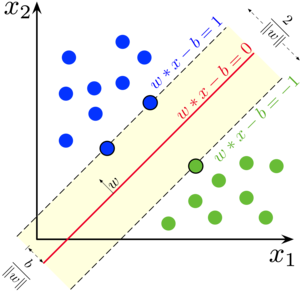

In [63]:
display.Image("./data/300px-SVM_margin.png")

Si vous voulez découvrir comment cet algorithme fonctionne, je vous invite à consulter ce lien (bases en maths requises).

Avant de tester le modèle, nous allons séparer nos données en un jeu d’entraînement et un jeu de test, afin d’évaluer la qualité de notre modèle, puis nous pouvons directement entraîner le modèle et effectuer des prédictions sur le jeu de test. Avec un score F1 assez élevé et une matrice de confusion concluante, nous pouvons voir que nos résultats sont bons.

In [142]:
X_train, X_test, y_train, y_test = train_test_split(df2, df.CLASS, test_size = 0.3)

clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('F1 Score :', f1_score(y_test, y_pred))

F1 Score : 0.9407783417935702


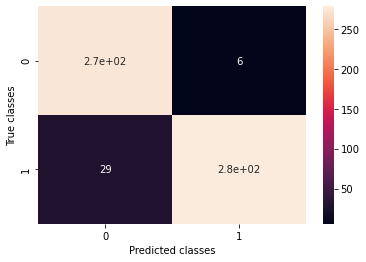

In [143]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.show()

In [177]:
misclass = (y_test != y_pred)
index_missclass = X_test.iloc[misclass.index,:]
index_missclass


,00,000,002,018,02,034,04,047000,05,053012,...,ｃｏｍｍｅｎｔ,ｄａｍｎ,ｅｂａｙ,ｆａｎｃy,ｈｔｔｐ,ｉｓ,ｓｈｏｅｃｏｌｌｅｃｔｏｒ314,ｔｈｉｓ,ｕｓｒ,ｗｗｗ
1444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
df_misspredict_comment = df[["CONTENT","CLASS"]].iloc[index_missclass.index,:]
df_misspredict_comment

,CONTENT,CLASS
306,CHECK OUT MY MUSIC VIDEO ON MY CHANEL!!!,1
185,It's so funny it's awesomeness lol aaaaaaa sex...,0
271,EMINEM&lt;3 <br />the best rapper ever&lt;3﻿,0
125,I loved this song when I was in my teenage yea...,0
13,Love song﻿,0
...,...,...
374,Check out this video on YouTube:it is a old tr...,1
155,Pleas subscribe my channel﻿,1
336,To everyone joking about how he hacked to get ...,0
40,LMFAO best songs ever!﻿,0
